This experiment looks at the effect of different kernel modes with the SVM alogithm when applied to NLP

First the leftover labels need to be merged with their most similar chosen label

In [13]:
label_names = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'
}

chosen_labels = [0, 1, 2, 3, 7, 10, 15, 17, 18, 20, 24, 25, 26]
chosen_label_names = []

for label in chosen_labels:
    chosen_label_names.append(label_names[label])

print("Chosen Labels:", chosen_label_names)

Chosen Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'curiosity', 'disapproval', 'gratitude', 'joy', 'love', 'optimism', 'remorse', 'sadness', 'surprise']


Get the dataset and create a matrix that describes the frequency of each label overlapping. This does not include the neutral label and relations of labels with themselves as this is useless information

In [14]:
import datasets
import torch

In [15]:
relation_matrix = torch.zeros((27,27)).type(torch.int)
emotions_dataset = datasets.load_dataset('go_emotions', split='train')

for row in emotions_dataset:
    labels = row['labels'][:-1]
    for main_label in labels:
        for relation_label in labels:
            relation_matrix[main_label][relation_label] += 1

print(relation_matrix[:10, :10])

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/ryans/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


tensor([[1420,   12,    0,    4,   43,   10,    7,    6,   14,    5],
        [  12,  604,    3,    7,    3,    1,    5,    3,    1,    1],
        [   0,    3,  525,   37,    2,    2,    0,    0,    0,    8],
        [   4,    7,   37,  735,    4,    0,    6,    5,    3,   24],
        [  43,    3,    2,    4,  775,   10,    0,    4,    4,    4],
        [  10,    1,    2,    0,   10,  338,    0,    4,    5,    4],
        [   7,    5,    0,    6,    0,    0,  428,   33,    0,    2],
        [   6,    3,    0,    5,    4,    4,   33,  435,    1,    6],
        [  14,    1,    0,    3,    4,    5,    0,    1,  182,    2],
        [   5,    1,    8,   24,    4,    4,    2,    6,    2,  372]],
       dtype=torch.int32)


Next create a mask to remove relations of unchosen labels to other unchosen labels. This means when we chose what labels to merge we will end up with only chosen labels left

In [16]:
mask = torch.ones((27,27)).type(torch.int)
unchosen_labels = list(range(27))

for label in chosen_labels:
    unchosen_labels.remove(label)

for label in unchosen_labels:
    mask[:, label].fill_(0.0)

for i in range(27):
    mask[i,i] = 0.0

print(mask[:10,:10])

tensor([[0, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0]], dtype=torch.int32)


Apply mask to relation matrix and find which unchosen labels should merge to which chosen labels

In [17]:
relation_matrix = relation_matrix * mask
print(relation_matrix[:10,:10])

label_mergers = dict()
for label in unchosen_labels:
    label_mergers[label] = torch.argmax(relation_matrix[label]).item()
for label in chosen_labels:
    label_mergers[label] = label
label_mergers[27] = 27

label_merger_names = dict()
for key, value in label_mergers.items():
    label_merger_names[label_names[key]] = label_names[value]

print(label_merger_names)

tensor([[ 0, 12,  0,  4,  0,  0,  0,  6,  0,  0],
        [12,  0,  3,  7,  0,  0,  0,  3,  0,  0],
        [ 0,  3,  0, 37,  0,  0,  0,  0,  0,  0],
        [ 4,  7, 37,  0,  0,  0,  0,  5,  0,  0],
        [43,  3,  2,  4,  0,  0,  0,  4,  0,  0],
        [10,  1,  2,  0,  0,  0,  0,  4,  0,  0],
        [ 7,  5,  0,  6,  0,  0,  0, 33,  0,  0],
        [ 6,  3,  0,  5,  0,  0,  0,  0,  0,  0],
        [14,  1,  0,  3,  0,  0,  0,  1,  0,  0],
        [ 5,  1,  8, 24,  0,  0,  0,  6,  0,  0]], dtype=torch.int32)
{'approval': 'admiration', 'caring': 'admiration', 'confusion': 'curiosity', 'desire': 'admiration', 'disappointment': 'annoyance', 'disgust': 'anger', 'embarrassment': 'admiration', 'excitement': 'admiration', 'fear': 'admiration', 'grief': 'annoyance', 'nervousness': 'love', 'pride': 'admiration', 'realization': 'amusement', 'relief': 'admiration', 'admiration': 'admiration', 'amusement': 'amusement', 'anger': 'anger', 'annoyance': 'annoyance', 'curiosity': 'curiosity', 'di

Next we apply the merging

In [18]:
label_occurances = dict()
for i in range(28):
    label_occurances[i] = 0

for row in emotions_dataset:
    for label in row['labels']:
        label_occurances[label] += 1

print(label_occurances)

{0: 4130, 1: 2328, 2: 1567, 3: 2470, 4: 2939, 5: 1087, 6: 1368, 7: 2191, 8: 641, 9: 1269, 10: 2022, 11: 793, 12: 303, 13: 853, 14: 596, 15: 2662, 16: 77, 17: 1452, 18: 2086, 19: 164, 20: 1581, 21: 111, 22: 1110, 23: 153, 24: 545, 25: 1326, 26: 1060, 27: 14219}


In [19]:
merged_labels = []
for i in range(len(emotions_dataset)):
    new_labels = emotions_dataset[i]['labels']
    for i in range(len(new_labels)):
        new_labels[i] = label_mergers[new_labels[i]]

    new_labels = list(set(new_labels))
    merged_labels.append(new_labels)

There are still multiple labels for some of the inputs so we need to chose only one label per input. This is done by trying to maximise the distrubution of all labels for a more even dataset.

In [20]:
label_occurances = dict()
for label in chosen_labels:
    label_occurances[label] = 0
label_occurances[27] = 0

for i in range(len(merged_labels)):
    min_label = merged_labels[i][0]
    for label in merged_labels[i]:
        if label_occurances[label] < label_occurances[min_label]:
            min_label = label
    
    label_occurances[min_label] += 1
    merged_labels[i] = min_label


print(label_occurances)
print(merged_labels)



{0: 7792, 1: 2794, 2: 2148, 3: 2774, 7: 2854, 10: 1961, 15: 2391, 17: 1420, 18: 2080, 20: 1510, 24: 545, 25: 1261, 26: 1057, 27: 12823}
[27, 27, 2, 0, 3, 26, 15, 20, 0, 27, 7, 1, 27, 0, 3, 3, 15, 2, 27, 1, 7, 0, 27, 27, 27, 2, 27, 25, 15, 27, 2, 7, 27, 7, 7, 17, 27, 0, 25, 27, 15, 18, 3, 27, 0, 10, 20, 27, 27, 27, 27, 27, 0, 27, 15, 10, 27, 27, 27, 15, 1, 0, 27, 0, 27, 15, 27, 1, 27, 0, 27, 0, 3, 27, 27, 27, 15, 0, 27, 1, 0, 0, 25, 0, 27, 25, 15, 3, 1, 27, 0, 27, 24, 18, 0, 27, 7, 27, 7, 27, 0, 3, 10, 27, 27, 0, 27, 7, 27, 15, 27, 0, 1, 27, 17, 27, 2, 2, 27, 27, 3, 0, 27, 3, 2, 26, 7, 2, 27, 17, 15, 27, 2, 27, 27, 3, 7, 1, 27, 2, 26, 0, 27, 27, 18, 3, 15, 0, 1, 1, 1, 15, 18, 10, 27, 27, 0, 0, 18, 27, 15, 27, 3, 27, 0, 27, 0, 27, 0, 7, 18, 27, 20, 27, 27, 0, 27, 0, 17, 27, 26, 7, 15, 26, 0, 10, 27, 17, 27, 7, 0, 2, 3, 0, 15, 27, 27, 2, 27, 18, 27, 7, 7, 3, 17, 10, 27, 15, 0, 27, 0, 18, 27, 7, 27, 26, 27, 26, 27, 25, 0, 15, 25, 18, 0, 20, 7, 0, 27, 27, 27, 17, 27, 2, 27, 0, 27, 0, 7, 20,

Plotting the distribution we can see which labels are more common than others

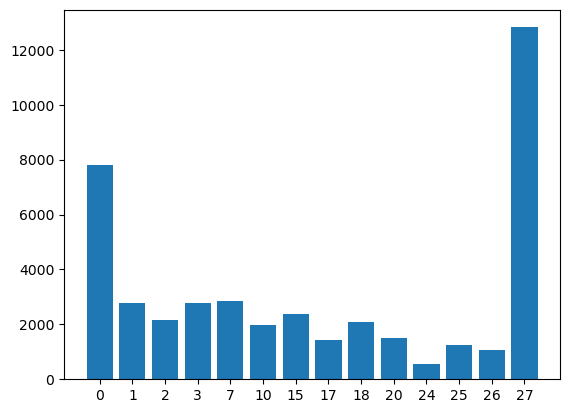

In [23]:
import matplotlib.pyplot as plt

plt.bar(x=list(map(str, label_occurances.keys())), height=list(label_occurances.values()))
plt.show()